import all libs for interactive sesion

In [2]:
import pyaudio
# imports
import matplotlib.pyplot as plt
import numpy as np
import wave, sys
import librosa # this is the cooler way to plot the sound
import librosa.display
import pandas as pd
import random
import math
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import scipy
from pydub import AudioSegment
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import VGG19

filename = "C:\sound\soundfiles\\recorded.wav"
filedir = "soundfiles//"
DATACSVPATH = "spec_data.csv"
FORMAT = pyaudio.paInt16
SAMPLERATE = 44100
SOUNDSAMPLESIZE = SAMPLERATE

c:\Python38-64\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


all file names and globals

Record files, split them, and generate training data

In [3]:
def recordAndSaveToFile(record_seconds = 60,_filename = filename ,channels =1,_sample_rate = SAMPLERATE,_chunk = 1024):
    p = pyaudio.PyAudio()
    stream = p.open( format=FORMAT,
    channels=channels,
    rate=_sample_rate,
    input=True,
    output=True,
    frames_per_buffer=_chunk)

    #record audio
    frames = []
    print("started recording")
    for i in range(int(_sample_rate /_chunk * record_seconds)):
        data = stream.read(_chunk)
        frames.append(data)
    print("stop")
    stream.stop_stream()
    stream.close()
    p.terminate()

    #save to .wav file
    wf = wave.open(filename, "wb")
    wf.setnchannels(channels)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(_sample_rate)
    wf.writeframes(b"".join(frames))
    wf.close()

def split_save_files(_filename=filename, _save_dir = filedir, _num_splits = 1):
    temp_aud = AudioSegment.from_file(_filename)
    temp_secs =  int(temp_aud.duration_seconds)

    #number of seconds in each variable
    interval = int(temp_secs / _num_splits)
    print(interval)
    for x in range(0,temp_secs,interval):
        t1 = x * 1000 # mesures in milli
        t2 = (x + interval) * 1000
        clip = temp_aud[t1:t2]
        temp_file_name =_save_dir + str(t1) + "_" + str(t2) + ".wav"
        clip.export(temp_file_name, format="wav")
        #does python go out of range?


def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

class pointGen:
   
    def __init__(self,radius: float,distance_mics = 10):
        self.origin = (0,0)
        self.X_max_value = radius
        self.X_min_value = -radius
        self.Y_max_value = radius
        self.Y_min_value = 0
        self.point_L_mic = (-distance_mics/2,0)
        self.point_R_mic = ( distance_mics/2,0)
        self.SPEEDOFSOUNDCMPS = 34300 #centimeater per second
    def genRandEe(self):
        output = random.uniform(self.X_min_value, self.X_max_value), random.uniform(self.Y_min_value, self.Y_max_value)
        print(output)
        dist_L_mic = math.dist(output,self.point_L_mic)
        dist_R_mic = math.dist(output,self.point_R_mic)
        time_to_L_mic = dist_L_mic / self.SPEEDOFSOUNDCMPS#centimeater per second
        time_to_R_mic = dist_R_mic / self.SPEEDOFSOUNDCMPS#centimeater per second
        return int((time_to_L_mic - time_to_R_mic)*SAMPLERATE),angle_between(output,self.origin)
        #find the distance
        
def gen_file_structure_and_csv(_filedir = filedir,_number_of_shifts_per_instance = 1):
    ch1dir = "ch1//"
    ch2dir = "ch2//"
    d = {'ch1_file': [], 'ch2_file': [], 'angle': [] , 'shift':[]}
    #df = pd.DataFrame(data=d)
    # generate a point
    _pg = pointGen(radius=60000,distance_mics=100)
    for file in os.listdir(_filedir):
        try:
            raw = wave.open(_filedir + file)
            signal = raw.readframes(-1)
            signal = np.frombuffer(signal, dtype ="int16")
            
            for ind in range(_number_of_shifts_per_instance):
                shift,angle = _pg.genRandEe()
                # shift file save copy
                ch2 = np.roll(signal,shift=shift)
                print(file,shift,signal)

                d['ch1_file'].append(str(_filedir+ ch1dir + str(ind) + "_" + file))
                d['ch2_file'].append(str(_filedir+ ch2dir + str(ind) + "_" + file))
                d['angle'].append(angle)
                d['shift'].append(shift)
                print(_filedir + ch1dir + str(ind)+ "_" + file)
                write(str(_filedir+ ch1dir + str(ind) + "_" + file), SAMPLERATE, signal)
                write(str(_filedir+ ch2dir + str(ind) + "_" + file), SAMPLERATE, ch2)
                
        except:
            print(file + "did not shift correctly")
        # split into ch1 dir and ch2 dir
    df = pd.DataFrame(data=d)
    df.to_csv(DATACSVPATH)
    return df
        

In [92]:
recordAndSaveToFile()

started recording
stop


In [93]:
split_save_files(_filename=filename,_save_dir=filedir,_num_splits=59)
df = gen_file_structure_and_csv(_number_of_shifts_per_instance=180)

1
(-52114.77661252045, 17162.362511423715)
0_1000.wav -122 [  0   0  -1 ... 272 258 239]
soundfiles//ch1//0_0_1000.wav
(-25688.848313422153, 25904.12918206505)
0_1000.wav -90 [  0   0  -1 ... 272 258 239]
soundfiles//ch1//1_0_1000.wav
(-20422.22643499051, 43792.485249037854)
0_1000.wav -54 [  0   0  -1 ... 272 258 239]
soundfiles//ch1//2_0_1000.wav
(39563.88021461938, 27152.458973454857)
0_1000.wav 106 [  0   0  -1 ... 272 258 239]
soundfiles//ch1//3_0_1000.wav
(-37480.825475742284, 556.4486686821524)
0_1000.wav -128 [  0   0  -1 ... 272 258 239]
soundfiles//ch1//4_0_1000.wav
(-34428.526412152925, 52712.575557578355)
0_1000.wav -70 [  0   0  -1 ... 272 258 239]
soundfiles//ch1//5_0_1000.wav
(-37885.11035943871, 18357.481283508278)
0_1000.wav -115 [  0   0  -1 ... 272 258 239]
soundfiles//ch1//6_0_1000.wav
(15105.805725135957, 2177.8172344295954)
0_1000.wav 127 [  0   0  -1 ... 272 258 239]
soundfiles//ch1//7_0_1000.wav
(1141.3546992138145, 47705.293279013844)
0_1000.wav 3 [  0   0  -1 

In [10]:
from IPython.display import Audio

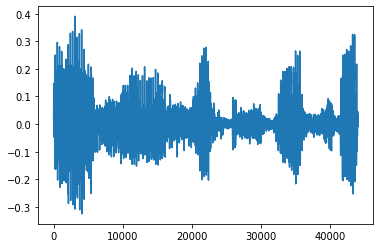

In [3]:
spec_test = pd.read_csv(DATACSVPATH).ch1_file
for i in spec_test.sample(1):
    idk = tf.io.read_file(i)
    idk,samp = ch1_audio,samp = tf.audio.decode_wav(idk,desired_channels=1,desired_samples=SOUNDSAMPLESIZE)
    audio_tensor = tf.squeeze(idk, axis=[-1])
    plt.plot(audio_tensor)

In [4]:
import tensorflow as tf
import tensorflow_io as tfio

Training code

In [30]:

def get_dataset(df):
    ch1_file_path_ds = tf.data.Dataset.from_tensor_slices(df.ch1_file)
    ch2_file_path_ds = tf.data.Dataset.from_tensor_slices(df.ch2_file)
    lables = tf.data.Dataset.from_tensor_slices(df.angle)
    return tf.data.Dataset.zip((ch1_file_path_ds,ch2_file_path_ds,lables))
# newds = get_dataset(df)
def get_dataset_ch1(df):
    ch1_file_path_ds = tf.data.Dataset.from_tensor_slices(df.ch1_file)
    ch2_file_path_ds = tf.data.Dataset.from_tensor_slices(df.ch2_file)
    lables = tf.data.Dataset.from_tensor_slices(df.angle)
    return ch1_file_path_ds
def get_dataset_ch2(df):
    ch1_file_path_ds = tf.data.Dataset.from_tensor_slices(df.ch1_file)
    ch2_file_path_ds = tf.data.Dataset.from_tensor_slices(df.ch2_file)
    lables = tf.data.Dataset.from_tensor_slices(df.angle)
    return ch2_file_path_ds
def get_dataset_label(df):
    ch1_file_path_ds = tf.data.Dataset.from_tensor_slices(df.ch1_file)
    ch2_file_path_ds = tf.data.Dataset.from_tensor_slices(df.ch2_file)
    lables = tf.data.Dataset.from_tensor_slices(df.angle)
    return lables
def get_dataset_spec(df):
    ch1_file_path_ds = tf.data.Dataset.from_tensor_slices(df.spec_gray_ch1_files)
    ch2_file_path_ds = tf.data.Dataset.from_tensor_slices(df.spec_gray_ch2_files)
    lables = tf.data.Dataset.from_tensor_slices(df.angle)
    return tf.data.Dataset.zip((ch1_file_path_ds,ch2_file_path_ds,lables))
# newds = get_dataset(df)




def load_audio(ch1_file_path,ch2_file_path,label):
    ch1_audio = tf.io.read_file(ch1_file_path)
    ch2_audio = tf.io.read_file(ch2_file_path)
    ch1_audio,samp = tf.audio.decode_wav(ch1_audio,desired_channels=1,desired_samples=4000)
    ch2_audio,samp = tf.audio.decode_wav(ch2_audio,desired_channels=1,desired_samples=4000)

    if label > 90:
        label = 1
    else:
        label = 0

    return [ch1_audio,ch2_audio],label

def get_class(label):
    if label > 90:
        label = 1
    else:
        label = 0

    return label


def load_audio_single(ch1_file_path):
    ch1_audio = tf.io.read_file(ch1_file_path)
    ch1_audio,samp = tf.audio.decode_wav(ch1_audio,desired_channels=1,desired_samples=4000)

    return ch1_audio,label

def load_images(ch1_file_path,ch2_file_path,label):
    ch1_audio = tf.io.read_file(ch1_file_path)
    ch1_audio = tf.image.decode_image(ch1_audio)

    ch2_audio = tf.io.read_file(ch2_file_path)
    ch2_audio = tf.image.decode_image(ch2_audio)
    

    return tf.concat([ch1_audio[:,:,:1],ch2_audio[:,:,:1]],axis=2),label

def load_images_vgg19(ch1_file_path,ch2_file_path,label):
    ch1_audio = tf.io.read_file(ch1_file_path)
    ch1_audio = tf.image.decode_image(ch1_audio)

    ch2_audio = tf.io.read_file(ch2_file_path)
    ch2_audio = tf.image.decode_image(ch2_audio)
    zez = tf.zeros(shape=(231, 240, 1))
    zez =tf.cast(zez, tf.uint8)
    vgout = tf.keras.applications.vgg19.preprocess_input(tf.concat([ch1_audio[:,:,:1],ch2_audio[:,:,:1],zez],axis=2), data_format=None)
    vgout = tf.image.resize(vgout, [224, 224])
    return vgout,label


def prepare_ds_for_training(ds,_batch):
    ds = ds.shuffle(buffer_size=1)
    ds = ds.map(load_audio,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.repeat()
    ds = ds.batch(_batch)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def prepare_single_ds_for_training(ds,_batch):
    ds = ds.map(load_audio_single,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return ds

def prepare_single_label_ds_for_training(ds,_batch):
    ds = ds.map(get_class,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return ds

def prepare_ds_for_training_spec(ds,_batch):
    ds = ds.shuffle(buffer_size=1)
    ds = ds.map(load_images,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.repeat()
    ds = ds.batch(_batch)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def prepare_ds_for_training_spec_vgg19(ds,_batch):
    ds = ds.shuffle(buffer_size=1)
    ds = ds.map(load_images_vgg19,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.repeat()
    ds = ds.batch(_batch)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
#################### multi head dataloader



dsch1 = prepare_single_ds_for_training(get_dataset_ch1(pd.read_csv(DATACSVPATH)),_batch=1)
dsch2 = prepare_single_ds_for_training(get_dataset_ch1(pd.read_csv(DATACSVPATH)),_batch=1)
for arr in dsch1.take(1):
    
    print(arr)

for arr in dsch2.take(1):
    
    print(arr)

(<tf.Tensor: shape=(4000, 1), dtype=float32, numpy=
array([[ 0.0000000e+00],
       [ 0.0000000e+00],
       [-3.0517578e-05],
       ...,
       [ 2.4414062e-04],
       [ 1.8310547e-04],
       [ 1.8310547e-04]], dtype=float32)>, <tf.Tensor: shape=(10,), dtype=float64, numpy=
array([161.77232721, 134.76092456, 115.00156383,  34.46158071,
       179.14943661, 123.15003392, 154.14718417,   8.20385465,
        88.62945327, 177.5448957 ])>)
(<tf.Tensor: shape=(4000, 1), dtype=float32, numpy=
array([[ 0.0000000e+00],
       [ 0.0000000e+00],
       [-3.0517578e-05],
       ...,
       [ 2.4414062e-04],
       [ 1.8310547e-04],
       [ 1.8310547e-04]], dtype=float32)>, <tf.Tensor: shape=(10,), dtype=float64, numpy=
array([161.77232721, 134.76092456, 115.00156383,  34.46158071,
       179.14943661, 123.15003392, 154.14718417,   8.20385465,
        88.62945327, 177.5448957 ])>)


In [46]:
######################### .wave dataloader
ds = prepare_ds_for_training(get_dataset(pd.read_csv(DATACSVPATH)),_batch=1)

for arr,arr2,label in ds.take(1):
    
    print(arr)

ValueError: not enough values to unpack (expected 3, got 2)

In [12]:
#spectrograms with color when 44.1k samples fed into FFT

ds = prepare_ds_for_training_spec(get_dataset_spec(pd.read_csv(DATACSVPATH)),_batch=10)

for arr,label in ds.take(1):
    print(arr)

tf.Tensor(
[[[[254 253]
   [255 255]
   [255 255]
   ...
   [255 255]
   [255 255]
   [255 255]]

  [[254 255]
   [255 255]
   [255 255]
   ...
   [255 255]
   [254 255]
   [255 254]]

  [[255 255]
   [253 252]
   [254 254]
   ...
   [255 255]
   [255 255]
   [255 255]]

  ...

  [[255 255]
   [255 255]
   [255 255]
   ...
   [255 255]
   [255 255]
   [255 255]]

  [[255 255]
   [255 255]
   [255 255]
   ...
   [255 255]
   [255 255]
   [255 255]]

  [[255 255]
   [255 255]
   [255 255]
   ...
   [255 255]
   [255 255]
   [255 255]]]


 [[[255 255]
   [254 255]
   [253 252]
   ...
   [255 255]
   [255 255]
   [255 255]]

  [[255 252]
   [254 255]
   [254 253]
   ...
   [255 255]
   [254 255]
   [254 254]]

  [[255 255]
   [255 255]
   [255 254]
   ...
   [255 255]
   [253 253]
   [255 255]]

  ...

  [[255 255]
   [255 255]
   [255 255]
   ...
   [255 255]
   [255 255]
   [255 255]]

  [[255 255]
   [255 255]
   [255 255]
   ...
   [255 255]
   [255 255]
   [255 255]]

  [[255 255]
   

In [31]:

################################## spectrograms with color when 44.1k samples fed into FFT

ds = prepare_ds_for_training_spec_vgg19(get_dataset_spec(pd.read_csv(DATACSVPATH)),_batch=10)

for arr,label in ds.take(1):
    print(arr)

tf.Tensor(
[[[[153.      137.10156 131.03572]
   [153.      139.      132.     ]
   [153.      138.99721 132.     ]
   ...
   [153.      139.      132.     ]
   [153.      139.      131.98605]
   [153.      138.98494 131.99944]]

  [[153.      138.99498 131.07758]
   [153.      138.86942 131.91127]
   [153.      138.79129 131.9615 ]
   ...
   [153.      139.      132.     ]
   [153.      139.      131.149  ]
   [153.      138.08092 131.96596]]

  [[153.      138.89844 131.93416]
   [153.      136.36215 130.23828]
   [153.      138.2009  131.0865 ]
   ...
   [153.      139.      131.98605]
   [153.      138.86049 132.     ]
   [153.      138.99442 132.     ]]

  ...

  [[153.      139.      132.     ]
   [153.      139.      132.     ]
   [153.      139.      132.     ]
   ...
   [153.      139.      132.     ]
   [153.      139.      132.     ]
   [153.      139.      132.     ]]

  [[153.      139.      132.     ]
   [153.      139.      132.     ]
   [153.      139.      132.     ]
 

In [43]:
'''model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(activation='relu',filters=1 , kernel_size=2 ,strides=2),
        #tf.keras.layers.MaxPool1D(pool_size=2,strides=2),
        #tf.keras.layers.Conv1D(activation='relu',filters=1, kernel_size=2 ,strides=2),
        #tf.keras.layers.MaxPool1D(pool_size=2,strides=2),
        #tf.keras.layers.Conv1D(activation='relu',filters=1 , kernel_size=2 ,strides=2),
        #tf.keras.layers.Conv1D(activation='relu',filters=1 , kernel_size=2 ,strides=2),
        #tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(activation='softmax',units=1),# this will be the number of classes # there should be a drop out
    ]
)'''
'''
        tf.keras.layers.Conv1D(activation='relu',filters=32 , kernel_size=2 ,dilation_rate = 2),
        tf.keras.layers.MaxPool1D(pool_size=2,strides=2),
        tf.keras.layers.Conv1D(activation='relu',filters=2, kernel_size=2  ,dilation_rate = 2),
        tf.keras.layers.MaxPool1D(pool_size=2,strides=2),
        tf.keras.layers.Conv1D(activation='relu',filters=32 , kernel_size=1 ,dilation_rate = 2),
        tf.keras.layers.Conv1D(activation='relu',filters=16 , kernel_size=2 ,dilation_rate = 2),
        tf.keras.layers.MaxPool1D(pool_size=2,strides=2),
        tf.keras.layers.Conv1D(activation='relu',filters=32 , kernel_size=1 ,dilation_rate = 2),
        tf.keras.layers.Conv1D(activation='relu',filters=16 , kernel_size=2 ,dilation_rate = 2),
        tf.keras.layers.MaxPool1D(pool_size=2,strides=2),
        tf.keras.layers.Conv1D(activation='relu',filters=32 , kernel_size=1 ,dilation_rate = 2),
        tf.keras.layers.Conv1D(activation='relu',filters=16 , kernel_size=2 ,dilation_rate = 2),
        tf.keras.layers.Dropout(.7),
'''

'''model = tf.keras.Sequential(
    [
        VGG19(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(activation='softmax',units=1),# this will be the number of classes # there should be a drop out
    ]
)'''

input_shape = (231, 240, 3)
'''
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(input_shape=input_shape[1:],filters =3,kernel_size=(3,432),strides=1,activation='relu'),#keras is dumb so i have to manualy make it do a 1d conv
        tf.keras.layers.Conv2D(filters =1,kernel_size=(2,432),strides=1,activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(activation='softmax',units=1),# this will be the number of classes # there should be a drop out
    ]
)'''

model = tf.keras.Sequential()
#model.add(tf.keras.layers.Input(shape=input_shape))  # 250x250 RGB images
#model.add(tf.keras.layers.Conv2D(32, 2, strides=(1,2), activation="relu"))
#model.add(tf.keras.layers.Conv2D(32, 2, strides=(1,2),activation="relu"))
#model.add(tf.keras.layers.Conv2D(32, 2, strides=(1,2),activation="relu"))
#model.add(tf.keras.layers.Conv2D(32, 2, strides=(1,2),activation="relu"))
#model.add(tf.keras.layers.MaxPooling2D(3))
#model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Conv1D(activation='relu',filters=32 , kernel_size=2 ,dilation_rate = 2))
#model.add(tf.keras.layers.MaxPool1D(pool_size=2,strides=2))

model.add(VGG19(weights=None))
model.add(tf.keras.layers.Dense(activation='softmax',units=1000))
model.add(tf.keras.layers.Dense(activation='softmax',units=100))
model.add(tf.keras.layers.Dense(activation='softmax',units=1)),# this will be the number of classes # there should be a drop out
#going to have to penalise guesses of a class that is way far off
# pass in to a rnn
# pass in a picto gram into a 2d network
# class ify an penalize guesses that are far off put in a third input 

learning_rate = .001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#outputs are not normalized so from_logits = 0
# this one may be wrong
loss_fn = tf.keras.losses.MeanAbsoluteError()
metrics =tf.keras.metrics.MeanAbsoluteError()
model.compile(optimizer=optimizer,loss=loss_fn,metrics=metrics)
# 


In [44]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1000)              143667240 
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1001      
Total params: 143,668,241
Trainable params: 143,668,241
Non-trainable params: 0
_________________________________________________________________


In [45]:
# RNN  experiment attempt
model.fit(ds,epochs=10,steps_per_epoch=30)

Epoch 1/10
30/30 [==============================] - 153s 5s/step - loss: 90.2317 - mean_absolute_error: 90.2316
Epoch 2/10
30/30 [==============================] - 156s 5s/step - loss: 84.7545 - mean_absolute_error: 84.7545
Epoch 3/10
30/30 [==============================] - 151s 5s/step - loss: 95.1797 - mean_absolute_error: 95.1797
Epoch 4/10
30/30 [==============================] - 151s 5s/step - loss: 85.8916 - mean_absolute_error: 85.8916
Epoch 5/10
30/30 [==============================] - 155s 5s/step - loss: 91.3101 - mean_absolute_error: 91.3101
Epoch 6/10
30/30 [==============================] - 159s 5s/step - loss: 88.9507 - mean_absolute_error: 88.9507
Epoch 7/10
29/30 [============================>.] - ETA: 5s - loss: 88.0469 - mean_absolute_error: 88.0469 

KeyboardInterrupt: 

In [134]:
# define two sets of inputs
inputA = tf.keras.layers.Input(shape=( 4000,1))
inputB = tf.keras.layers.Input(shape=( 4000,1))
# the first branch operates on the first input
modela = tf.keras.Sequential(
    [
        inputA,
        tf.keras.layers.Conv1D(activation='relu',filters=320 , kernel_size=1),
        tf.keras.layers.Conv1D(activation='relu',filters=200 , kernel_size=1),
        tf.keras.layers.Dense(activation='softmax',units=4000)
    ]
)

modelb = tf.keras.Sequential(
    [
        inputB,
        tf.keras.layers.Conv1D(activation='relu',filters=320 , kernel_size=1),
        tf.keras.layers.Conv1D(activation='relu',filters=200 , kernel_size=1),
        tf.keras.layers.Dense(activation='softmax',units=4000)
    ]
)

# combine the output of the two branches
combined = tf.keras.layers.concatenate([modela.output, modelb.output],axis=1)


combined.shape
#dual input

TensorShape([None, 8000, 4000])

In [135]:




#output = tf.keras.layers.Dense(units=2)(core)



model_tail = tf.keras.layers.Dense(2,activation='relu')(combined)
model_tail = tf.keras.layers.Conv1D(activation='relu',filters=320 , kernel_size=1)(model_tail)
model_tail =tf.keras.layers.Conv1D(activation='relu',filters=200 , kernel_size=2)(model_tail)
model_tail =tf.keras.layers.Conv1D(activation='relu',filters=32 , kernel_size=1)(model_tail)
model_tail =tf.keras.layers.Conv1D(activation='relu',filters=32 , kernel_size=1)(model_tail)
model_tail =tf.keras.layers.Dense(activation='softmax',units=1)
model_tail =tf.keras.layers.Dense(activation='softmax',units=1)(model_tail)# this will be the number of classes # there should be a drop out


model = tf.keras.Model(inputs=[modela.input,modelb.input],outputs=model_tail)
#resnet_model = tf.keras.Model(inputs=[input_layer], outputs=[output], name="audio_model")
#going to have to penalise guesses of a class that is way far off
# pass in to a rnn
# pass in a picto gram into a 2d network
# class ify an penalize guesses that are far off put in a third input 

learning_rate = .001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#outputs are not normalized so from_logits = 0
# this one may be wrong
loss_fn = tf.keras.losses.BinaryCrossentropy(reduction="auto")
metrics =tf.keras.metrics.BinaryAccuracy()
model.compile(optimizer=optimizer,loss=loss_fn,metrics=metrics)



In [136]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_92 (InputLayer)           [(None, 4000, 1)]    0                                            
__________________________________________________________________________________________________
input_93 (InputLayer)           [(None, 4000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_445 (Conv1D)             (None, 4000, 320)    640         input_92[0][0]                   
__________________________________________________________________________________________________
conv1d_447 (Conv1D)             (None, 4000, 320)    640         input_93[0][0]                   
____________________________________________________________________________________________

In [ ]:
#yeet
model.fit(ds,epochs=10,steps_per_epoch=30)


In [129]:

###################### fitting into multihead model needs more input engineering

dsch1 = prepare_single_ds_for_training(get_dataset_ch1(pd.read_csv(DATACSVPATH)),_batch=1)
dsch2 = prepare_single_ds_for_training(get_dataset_ch1(pd.read_csv(DATACSVPATH)),_batch=1)
dslabel = prepare_single_label_ds_for_training(get_dataset_label(pd.read_csv(DATACSVPATH)),_batch=1)
bsds1 = []
bsds2 = []
bsdslab = []
for arr in dsch1:
    bsds1.append(arr)
    print

for arr in dsch2:
    bsds2.append(arr)

for arr in dslabel:
    bsdslab.append(arr)

bsds2.shape


AttributeError: 'list' object has no attribute 'shape'

In [137]:
for arr in dsch1.take(1):
    bsds1.append(arr)
    print(arr)


(<tf.Tensor: shape=(4000, 1), dtype=float32, numpy=
array([[ 0.0000000e+00],
       [ 0.0000000e+00],
       [-3.0517578e-05],
       ...,
       [ 2.4414062e-04],
       [ 1.8310547e-04],
       [ 1.8310547e-04]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>)


In [138]:

####################### this will fit to multi head arcitecture
model.fit([bsds1, bsds2], bsdslab)

IndexError: list index out of range

In [ ]:
#pass in averageParallelMapDataset